# 7.3.2 LSTMCell

### 라이브러리 호출

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter # 파라미터 목록을 갖고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math # 수학과 관련된 라이브러리

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False # GPU 사용에 필요

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor # GPU 사용에 필요

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

### 데이터 전처리

In [ ]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,)) # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화
])

### 데이터셋 내려받기

In [ ]:
from torchvision.datasets import MNIST

download_root = 'MNIST_DATASET/' # 내려받을 경로

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True) # 내려받을 위치, 전처리 적용, 훈련용 데이터셋, 내려받으려는 위치에 파일이 있다면 내려받지 않음
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34827295.79it/s]


Extracting MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1278908.91it/s]


Extracting MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9500672.99it/s]


Extracting MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9343074.43it/s]


Extracting MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



### 데이터셋을 메모리로 가져오기

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

### 변수 값 지정 (배치 크기, 에포크)

In [ ]:
batch_size = 100
n_iters = 6000 # 총 반복 횟수
num_epochs = n_iters / (len(train_dataset) / batch_size)
# len(train_dataset) : 훈련 데이터셋의 총 샘플 수
# batch_size : 한 번에 모델을 통과시킬 샘플의 수
# len(train_dataset) / batch_size : 한 번의 epoch에 필요한 배치 수
# n_iters / (len(train_dataset) / batch_size) : n_iters 번의 반복을 완료하는 데 필요한 총 에폭 수
num_epochs = int(num_epochs)

### LSTM 셀 네트워크 구축

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias) # gates가 망각, 입력, 셀, 출력 4개로 쪼개지기 때문에 4를 곱한다
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self): # 모델의 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size) # 표준편차 계산
        for w in self.parameters(): # 모든 파라미터에 대해 반복
            w.data.uniform_(-std, std) # 균등 분포를 따르는 난수로 초기화

    def forward(self, x, hidden):
        hx, cx = hidden  # 은닉 상태와 셀 상태를 가져옴
        x = x.view(-1, x.size(1))  # 입력 데이터를 2D 텐서로 변환

        gates = self.x2h(x) + self.h2h(hx)  # 입력과 은닉 상태에 대한 선형 변환을 수행하여 gate 값을 계산
        gates = gates.squeeze()  # 차원을 축소하여 차원을 맞춤
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1) # gate 값을 4개로 분할. 열 단위로 분할함

        ingate = F.sigmoid(ingate)  # 입력 게이트의 활성화 함수 적용
        forgetgate = F.sigmoid(forgetgate)  # 망각 게이트의 활성화 함수 적용
        cellgate = F.tanh(cellgate)  # 셀 상태의 새로운 후보 값에 대한 하이퍼볼릭 탄젠트 활성화 함수 적용
        outgate = F.sigmoid(outgate)  # 출력 게이트의 활성화 함수 적용

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)  # 셀 상태 업데이트
        hy = torch.mul(outgate, F.tanh(cy))  # 은닉 상태 업데이트
        return (hy, cy)  # 새로운 은닉 상태와 셀 상태 반환


### LSTM 셀의 전반적인 네트워크

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim  # 은닉 상태의 차원 수
        self.layer_dim = layer_dim  # LSTM 층의 수
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)  # LSTM 셀 정의
        self.fc = nn.Linear(hidden_dim, output_dim)  # 출력층 정의

    def forward(self, x):
        # 초기 은닉 상태 및 셀 상태 생성
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available(): # GPU 사용 유무 확인
            # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태를 0으로 초기화
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        cn = c0[0,:,:]  # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태에 대한 텐서
        hn = h0[0,:,:]  # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태에 대한 텐서

        # 시퀀스 데이터를 반복하여 모델을 통과시킴
        for seq in range(x.size(1)): # LSTM 셀 계층을 반복하여 쌓아 올린다
            hn, cn = self.lstm(x[:,seq,:], (hn, cn))  # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장
            outs.append(hn)  # 각 시퀀스의 출력을 저장

        out = outs[-1].squeeze()  # 마지막 시퀀스의 출력만 선택하여 2D 텐서로 변환
        out = self.fc(out)  # 출력층을 통과하여 최종 출력 생성
        return out  # 최종 출력 반환


### 옵티마이저와 손실 함수 지정

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available(): # GPU 사용 유무 확인
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 모델 학습 및 성능 확인

In [ ]:
seq_dim = 28  # 시퀀스 길이 (입력 시퀀스의 길이 = 이미지의 높이)
loss_list = []  # 손실 함수 값 기록 리스트
iter = 0  # 반복 횟수 초기화

for epoch in range(num_epochs):  # 주어진 에폭 수만큼 반복
    for i, (images, labels) in enumerate(train_loader):  # 훈련 데이터셋을 이용한 모델 학습
        if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())  # 이미지를 모델에 맞는 형태로 변환하여 GPU에 할당
            labels = Variable(labels.cuda())  # 레이블을 GPU에 할당
        else:  # GPU를 사용하지 않는 경우
            images = Variable(images.view(-1, seq_dim, input_dim))  # 이미지를 모델에 맞는 형태로 변환
            labels = Variable(labels)  # 레이블을 변수로 변환

        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델을 통해 출력 계산
        loss = criterion(outputs, labels)  # 손실 함수를 이용하여 오차 계산

        if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
            loss.cuda()  # 손실을 GPU에 할당

        loss.backward()  # 역전파 수행
        optimizer.step()  # 파라미터 업데이트
        loss_list.append(loss.item())  # 손실 값을 리스트에 저장
        iter += 1  # 반복 횟수 증가

        if iter % 500 == 0:  # 일정 주기마다 정확도 계산
            correct = 0
            total = 0
            for images, labels in valid_loader:  # 검증 데이터셋을 이용하여 모델 성능 검증
                if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())  # 이미지를 모델에 맞는 형태로 변환하여 GPU에 할당
                else:  # GPU를 사용하지 않는 경우
                    images = Variable(images.view(-1 , seq_dim, input_dim))  # 이미지를 모델에 맞는 형태로 변환

                outputs = model(images)  # 모델을 통해 출력 계산
                _, predicted = torch.max(outputs.data, 1)  # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

                total += labels.size(0)  # 총 레이블 수
                if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
                    correct += (predicted.cpu() == labels.cpu()).sum()  # 정확하게 예측된 레이블 수 계산
                else:  # GPU를 사용하지 않는 경우
                    correct += (predicted == labels).sum()  # 정확하게 예측된 레이블 수 계산

            accuracy = 100 * correct / total  # 정확도 계산
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))  # 현재 반복 횟수, 손실 값, 정확도 출력


Iteration: 500. Loss: 2.237457275390625. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 0.9968994855880737. Accuracy: 74.94999694824219
Iteration: 1500. Loss: 0.42673957347869873. Accuracy: 88.13999938964844
Iteration: 2000. Loss: 0.30981600284576416. Accuracy: 93.56999969482422
Iteration: 2500. Loss: 0.0558248832821846. Accuracy: 95.69000244140625
Iteration: 3000. Loss: 0.09873700886964798. Accuracy: 95.58000183105469
Iteration: 3500. Loss: 0.08254366368055344. Accuracy: 96.8499984741211
Iteration: 4000. Loss: 0.03308983892202377. Accuracy: 97.08000183105469
Iteration: 4500. Loss: 0.049307383596897125. Accuracy: 97.08000183105469
Iteration: 5000. Loss: 0.08068697154521942. Accuracy: 96.69999694824219
Iteration: 5500. Loss: 0.12790139019489288. Accuracy: 97.30999755859375
Iteration: 6000. Loss: 0.007093742024153471. Accuracy: 97.66000366210938
Iteration: 6500. Loss: 0.011727366596460342. Accuracy: 97.63999938964844
Iteration: 7000. Loss: 0.008610538206994534. Accuracy: 98.06999969

### 테스트 데이터셋을 이용한 모델 예측 성능 확인

In [ ]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()  # 모델을 평가 모드로 설정
    for images, labels in val_iter:  # 검증 데이터셋을 이용하여 모델 성능 평가
        if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())  # 이미지를 모델에 맞는 형태로 변환하여 GPU에 할당
        else:  # GPU를 사용하지 않는 경우
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)  # 이미지를 모델에 맞는 형태로 변환하여 디바이스에 할당
        labels = labels.cuda()  # 레이블을 GPU에 할당

        logit = model(images).cuda()  # 모델을 통해 로짓 계산. 로짓 : 각 클래스에 대한 점수
        loss = F.cross_entropy(logit, labels, reduction="sum")  # 손실 계산
        _, predicted = torch.max(logit.data, 1)  # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기
        total += labels.size(0)  # 총 레이블 수 업데이트
        total_loss += loss.item()  # 총 손실 업데이트
        corrects += (predicted == labels).sum()  # 정확하게 예측된 레이블 수 업데이트

    avg_loss = total_loss / len(val_iter.dataset)  # 평균 손실 계산
    avg_accuracy = corrects / total  # 평균 정확도 계산
    return avg_loss, avg_accuracy  # 평균 손실과 평균 정확도 반환

### 모델 예측 성능 확인

In [ ]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


# 7.5.3 LSTM 계층 구현

### 라이브러리 호출

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 데이터셋 가져오기 (스타벅스 주가 데이터)

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap07/data/SUBX.csv 데이터 불러오기
data=pd.read_csv('SBUX.csv')
print(data.dtypes)

Saving SBUX.csv to SBUX.csv
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


### 날짜 칼럼을 인덱스로 사용

In [ ]:
data['Date'] = pd.to_datetime(data['Date']) # Date 열의 데이터를 날짜(datetime) 형식으로 변환
data.set_index('Date', inplace=True) # date 칼럼을 인덱스로 사용

### 데이터 형식 변경

In [ ]:
data['Volume'] = data['Volume'].astype(float) # 정수(int) -> 실수(float)

### 훈련과 레이블 분리

In [ ]:
X=data.iloc[:,:-1] # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y=data.iloc[:,5:6] # 마지막 'Volume'을 레이블로 사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2023-05-10  107.160004  108.110001  105.680000  106.970001  104.667084
2023-05-11  106.440002  106.760002  105.120003  105.629997  103.870567
2023-05-12  105.760002  106.220001  104.830002  106.120003  104.352417
2023-05-15  106.110001  106.760002  105.610001  106.639999  104.863747
2023-05-16  106.410004  106.559998  105.199997  105.279999  103.526405
...                ...         ...         ...         ...         ...
2024-05-03   75.269997   75.510002   72.989998   73.110001   73.110001
2024-05-06   73.309998   74.190002   72.699997   72.900002   72.900002
2024-05-07   72.849998   72.849998   71.800003   72.500000   72.500000
2024-05-08   72.290001   74.470001   72.250000   73.500000   73.500000
2024-05-09   73.570000   75.760002   73.070000   75.680000   75.680000

[252 rows x 5 columns]
                Volume
Date                  
2023-05

### 데이터 분포 조정

In [ ]:
ms = MinMaxScaler() # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :] # 훈련 데이터셋
X_test = X_ss[200:, :] # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape) # 훈련 데이터셋은 200개의 데이터와 5개의 칼럼으로 구성되어 있다
print("Testing Shape", X_test.shape, y_test.shape) # 테스트 데이터셋은 52개의 데이터와 1개의 칼럼으로 구성되어 있다

Training Shape (200, 5) (200, 1)
Testing Shape (52, 5) (52, 1)


### 데이터셋의 형태 및 크기 조정

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train)) # Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# 훈련 데이터셋(X_train_tensors)의 형태 (200, 5)를 (200, 1, 5)로 변경하겠다는 의미
# LSTM 네트워크의 입력 형태와 맞추기 위함이다
X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([52, 1, 5]) torch.Size([52, 1])


### LSTM 네트워크

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

### 변수 값 설정

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터셋의 칼럼(feature) 개수
hidden_size = 2 # 은닉층의 유닛 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 모델 학습

In [ ]:
for epoch in range(num_epochs): # 1000번 반복
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 손실 함수를 이용한 오차 계산
    loss.backward() # 기울기 계산

    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00286
Epoch: 100, loss: 0.00277
Epoch: 200, loss: 0.00276
Epoch: 300, loss: 0.00275
Epoch: 400, loss: 0.00274
Epoch: 500, loss: 0.00273
Epoch: 600, loss: 0.00272
Epoch: 700, loss: 0.00269
Epoch: 800, loss: 0.00267
Epoch: 900, loss: 0.00265


### 모델 예측 결과를 출력하기 위한 데이터 크기 재구성

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1]) # 데이터 정규화. 평균을 0, 표준 편차를 1로 만들어
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

### 모델 예측 결과 출력

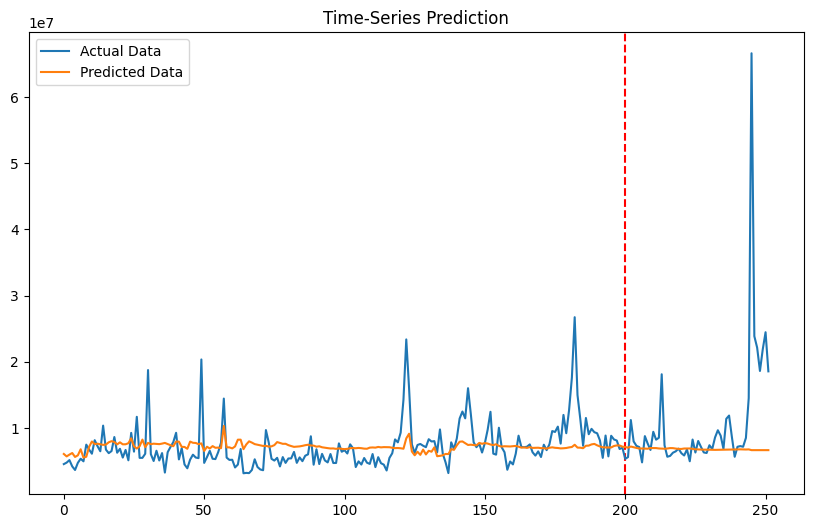

In [ ]:
train_predict = model(df_x_ss) # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) # 모델 학습을 위해 정규화했던 것을 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) # 그래프로 표시(plotting)
plt.axvline(x=200, c='r', linestyle='--') # 그래프의 축을 따라 수직선을 표현

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

# 7.6.2 GRU 셀 구현

### 라이브러리 호출

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# 랜덤 시드를 설정하여 코드 실행 시 재현 가능한 결과를 얻습니다.
torch.manual_seed(125)
# GPU를 사용할 수 있는 경우, GPU에 대한 랜덤 시드를 설정합니다.
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

### 데이터 전처리

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변경
    transforms.Normalize((0.5,), (1.0,)) # 평균과 표준편차를 기준으로 정규화
])

### 데이터셋 내려받기 및 전처리 적용 (MNIST 데이터셋)

In [ ]:
from torchvision.datasets import MNIST
download_root = 'MNIST_DATASET/'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4399346.45it/s]


Extracting MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133134.58it/s]


Extracting MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1226425.85it/s]


Extracting MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10607198.65it/s]

Extracting MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



### 데이터셋 메모리로 가져오기

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True) # 일반적으로 검증과 테스트 데이터셋은 섞어서 사용하지 않는다
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

### 변수 값 설정

In [ ]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
# (len(train_dataset) / batch_size) : 한번의 epoch에 필요한 반복 횟수
# 총 epoch 수 = 총 반복 횟수 / 한번의 epoch에 필요한 반복 횟수
num_epochs = int(num_epochs)

### GRU 셀 네트워크

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias) # 입력에서 hidden 상태로 가는 선형 변환
                                                                     # 3개의 게이트가 사용되므로 3을 곱함
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias) # hidden 상태에서 hidden 상태로 가는 선형 변환
        self.reset_parameters() # 파라미터 초기화

    def reset_parameters(self): # 파라미터 초기화 함수
        std = 1.0 / math.sqrt(self.hidden_size) # 표준 편차 계산
        for w in self.parameters():
            w.data.uniform_(-std, std) # 가중치 값을 균등 분포에서 랜덤하게 초기화
                                       # 초기화되는 값은 -std와 std 사이의 값

    def forward(self, x, hidden):
        x = x.view(-1, x.size(1)) # 입력 데이터의 형태를 맞춤

        # 입력과 이전 hidden 상태를 이용하여 3개의 게이트에 대한 연산 수행
        # LSTM 셀에서는 gates를 x2h + h2h로 정의했지만, GRU 셀에서는 개별적인 상태를 유지한다
        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)

        gate_x = gate_x.squeeze() # 차원을 줄임
        gate_h = gate_h.squeeze() # 차원을 줄임

        # gate_x, gate_h를 각 게이트(i_r, i_i, i_n), (h_r, h_i, h_n)으로 나눔
        i_r, i_i, i_n = gate_x.chunk(3, 1) # (리셋 게이트, 입력 게이트, 새로운 게이트)로 쪼갠다
        h_r, h_i, h_n = gate_h.chunk(3, 1) # (리셋 게이트, 입력 게이트, 새로운 게이트)로 쪼갠다

        # 게이트들에 시그모이드 및 하이퍼볼릭 탄젠트 함수를 적용하여 각 게이트의 값을 계산
        resetgate = F.sigmoid(i_r + h_r) # 리셋 게이트
        inputgate = F.sigmoid(i_i + h_i) # 입력 게이트
        newgate = F.tanh(i_n + (resetgate * h_n)) # 새로운 게이트

        # 새로운 hidden 상태 계산
        hy = (1 - inputgate) * hidden + inputgate * newgate
        return hy


### 전반적인 네트워크 구조

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRUCell을 사용하여 GRU 모델 정의
        self.gru_cell = GRUCell(input_dim, hidden_dim, bias)
        # 출력을 위한 선형 레이어 정의
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 초기 hidden 상태 생성
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) # 크기가 (layer_dim, batch_size, hidden_dim)인 초기 hidden 상태 텐서
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        hn = h0[0,:,:] # 초기 hidden 상태

        # 각 시퀀스마다 GRU 셀을 통과하여 hidden 상태 업데이트
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn)
            outs.append(hn)

        out = outs[-1].squeeze() # 마지막 시퀀스의 hidden 상태를 출력으로 사용
        out = self.fc(out) # 출력을 위해 선형 레이어를 통과시킴
        return out


### 옵티마이저와 손실 함수 설정

In [ ]:
input_dim = 28 # 입력 데이터의 특성수
hidden_dim = 128 # hidden 상태의 차원
layer_dim = 1 # 순환 신경망의 레이어수
output_dim = 10 # 출력 특성수

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 모델 학습 및 성능 검증

In [ ]:
seq_dim = 28 # 시퀀스 데이터의 길이 (순환 신경망에 입력되는 데이터의 길이)
loss_list = []
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # GPU를 사용할 수 있는지 확인
        if torch.cuda.is_available():
            # 이미지와 레이블을 변수로 변환하고 GPU로 이동
            images = Variable(images.view(-1, seq_dim, input_dim).cuda()) # 입력 이미지 형태 변환
            labels = Variable(labels.cuda())
        else:
            # 이미지와 레이블을 변수로 변환
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        # 경사 초기화
        optimizer.zero_grad()

        # 모델에 이미지 전달하여 출력 계산
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)

        # GPU를 사용할 수 있는 경우 손실을 GPU로 이동
        if torch.cuda.is_available():
            loss.cuda()

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 기록
        loss_list.append(loss.item())
        iter += 1

        # 일정 간격마다 검증 데이터에 대한 정확도 출력
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    # 검증 이미지를 변수로 변환하고 GPU로 이동
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    # 검증 이미지를 변수로 변환
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                # 모델을 통해 이미지 전달하여 출력 계산
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    # 정확도 계산을 위해 CPU로 이동한 후 정확한 예측 수 계산
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            # 정확도 출력
            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 1.6616928577423096. Accuracy: 43.59000015258789
Iteration: 1000. Loss: 0.8945668339729309. Accuracy: 76.19999694824219
Iteration: 1500. Loss: 0.29147759079933167. Accuracy: 89.7300033569336
Iteration: 2000. Loss: 0.23627927899360657. Accuracy: 93.51000213623047
Iteration: 2500. Loss: 0.03288726136088371. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.030374974012374878. Accuracy: 95.81999969482422
Iteration: 3500. Loss: 0.16210567951202393. Accuracy: 96.33999633789062
Iteration: 4000. Loss: 0.19308766722679138. Accuracy: 96.19000244140625
Iteration: 4500. Loss: 0.051720067858695984. Accuracy: 97.0
Iteration: 5000. Loss: 0.13900163769721985. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.08090294152498245. Accuracy: 97.62000274658203
Iteration: 6000. Loss: 0.10488356649875641. Accuracy: 97.69000244140625
Iteration: 6500. Loss: 0.07984025031328201. Accuracy: 97.80000305175781
Iteration: 7000. Loss: 0.10250380635261536. Accuracy: 97.55999755859375
Iterati

### 테스트 데이터셋을 이용한 모델 예측

In [ ]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
        labels = labels.cuda()
        logit = model(images).cuda()
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

### 모델 예측 결과

In [ ]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


# 7.6.3 GRU 계층 구현

### 라이브러리 호출

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 데이터셋 불러오기 (스타벅스 주가 데이터셋)

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap07/data/SUBX.csv 데이터 불러오기
data=pd.read_csv('SBUX.csv')
print(data.dtypes)

Saving SBUX.csv to SBUX.csv
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


### 인덱스 설정 및 데이터 타입 변경

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True) # Date 칼럼을 인덱스로 지정
data['Volume'] = data['Volume'].astype(float) # Volume 칼럼의 데이터 형식을 실수로 변경

### 훈련과 레이블 데이터셋 분리

In [ ]:
X=data.iloc[:,:-1] # 마지막 칼럼을 제외한 모든 데이터셋을 x(훈련 용도)로 지정
y=data.iloc[:,5:6] # 마지막 칼럼을 레이블(y)로 지정
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2023-05-10  107.160004  108.110001  105.680000  106.970001  104.667084
2023-05-11  106.440002  106.760002  105.120003  105.629997  103.870567
2023-05-12  105.760002  106.220001  104.830002  106.120003  104.352417
2023-05-15  106.110001  106.760002  105.610001  106.639999  104.863747
2023-05-16  106.410004  106.559998  105.199997  105.279999  103.526405
...                ...         ...         ...         ...         ...
2024-05-03   75.269997   75.510002   72.989998   73.110001   73.110001
2024-05-06   73.309998   74.190002   72.699997   72.900002   72.900002
2024-05-07   72.849998   72.849998   71.800003   72.500000   72.500000
2024-05-08   72.290001   74.470001   72.250000   73.500000   73.500000
2024-05-09   73.570000   75.760002   73.070000   75.680000   75.680000

[252 rows x 5 columns]
                Volume
Date                  
2023-05

### 훈련과 테스트 데이터셋 정규화

In [ ]:
ms = MinMaxScaler() # MinMaxScaler 객체 생성
ss = StandardScaler() # StandardScaler 객체 생성

X_ss = ss.fit_transform(X) # 입력 데이터를 표준화(Standardization)합니다.
y_ms = ms.fit_transform(y) # 타겟 데이터를 Min-Max 스케일링(Min-Max Scaling)합니다.

# 표준화된 입력 데이터와 스케일링된 타겟 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train = X_ss[:200, :] # 처음 200개의 샘플을 훈련 세트로 사용합니다.
X_test = X_ss[200:, :]  # 나머지를 테스트 세트로 사용합니다.

y_train = y_ms[:200, :] # 처음 200개의 샘플을 훈련 세트의 타겟 값으로 사용합니다.
y_test = y_ms[200:, :]  # 나머지를 테스트 세트의 타겟 값으로 사용합니다.

print("Training Shape", X_train.shape, y_train.shape) # 훈련 세트의 형태 출력
print("Testing Shape", X_test.shape, y_test.shape)    # 테스트 세트의 형태 출력

Training Shape (200, 5) (200, 1)
Testing Shape (52, 5) (52, 1)


### 데이터셋 형태 변경 (LSTM에 적용하기 위함)

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train)) # 훈련 세트의 입력 데이터를 PyTorch Tensor로 변환합니다.
X_test_tensors = Variable(torch.Tensor(X_test))   # 테스트 세트의 입력 데이터를 PyTorch Tensor로 변환합니다.

y_train_tensors = Variable(torch.Tensor(y_train)) # 훈련 세트의 타겟 데이터를 PyTorch Tensor로 변환합니다.
y_test_tensors = Variable(torch.Tensor(y_test))   # 테스트 세트의 타겟 데이터를 PyTorch Tensor로 변환합니다.

# 입력 데이터의 차원을 변경하여 (샘플 수, 시퀀스 길이, 피쳐 수) 형태로 변환합니다.
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape) # 훈련 세트의 형태 출력
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)    # 테스트 세트의 형태 출력


Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([52, 1, 5]) torch.Size([52, 1])


### GRU 모델의 네트워크

In [ ]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태에 대해 0으로 초기화
                                                                                  # LSTM은 셀 상태가 있었지만 GRU는 셀 상태를 정의하지 않는다
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

### 옵티마이저와 손실 함수 지정

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 모델 학습

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00313
Epoch: 100, loss: 0.00266
Epoch: 200, loss: 0.00258
Epoch: 300, loss: 0.00252
Epoch: 400, loss: 0.00246
Epoch: 500, loss: 0.00239
Epoch: 600, loss: 0.00233
Epoch: 700, loss: 0.00228
Epoch: 800, loss: 0.00222
Epoch: 900, loss: 0.00218


### 그래프 출력을 위한 전처리

In [ ]:
# 입력 데이터를 표준화합니다.
df_x_ss = ss.transform(data.iloc[:, :-1])
# 타겟 데이터를 Min-Max 스케일링합니다.
df_y_ms = ms.transform(data.iloc[:, -1:])

# PyTorch Tensor로 입력 데이터를 변환합니다.
df_x_ss = Variable(torch.Tensor(df_x_ss))
# PyTorch Tensor로 타겟 데이터를 변환합니다.
df_y_ms = Variable(torch.Tensor(df_y_ms))
# 입력 데이터의 차원을 변경하여 (샘플 수, 시퀀스 길이, 피쳐 수) 형태로 변환합니다.
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

### 모델 예측 결과 출력

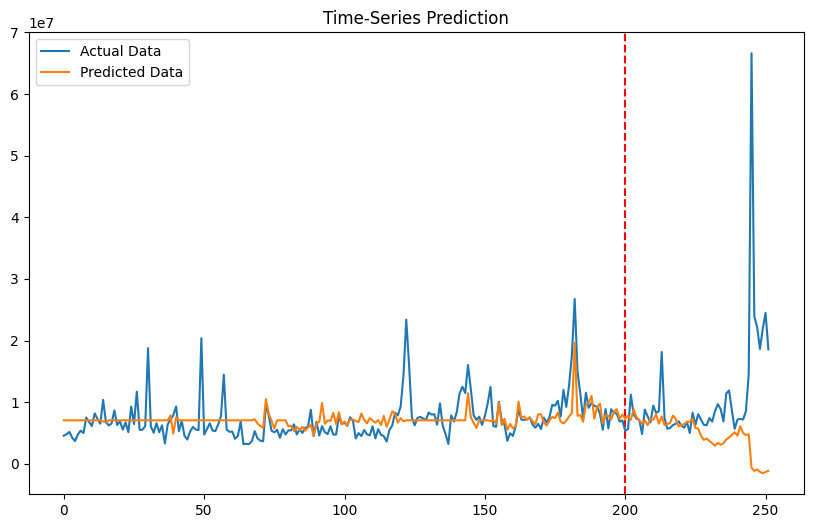

In [ ]:
# 훈련된 모델을 사용하여 입력 데이터에 대한 예측값 계산
train_predict = model(df_x_ss)
# 예측값을 NumPy 배열로 변환
predicted = train_predict.data.numpy()
# 타겟 데이터를 NumPy 배열로 변환
label_y = df_y_ms.data.numpy()

# 예측값을 역변환하여 원래 스케일로 되돌립니다.
predicted = ms.inverse_transform(predicted)
# 타겟 데이터를 역변환하여 원래 스케일로 되돌립니다.
label_y = ms.inverse_transform(label_y)

# 시각화
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--') # 훈련 데이터와 테스트 데이터의 경계를 나타내는 선 추가

plt.plot(label_y, label='Actual Data') # 실제 데이터 그래프
plt.plot(predicted, label='Predicted Data') # 예측 데이터 그래프
plt.title('Time-Series Prediction') # 그래프 제목
plt.legend() # 범례 표시
plt.show() # 그래프 출력

# 7.7.2 양방향 LSTM 구현

### 모델을 생성하고 학습

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
data=pd.read_csv('SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
data['Volume'] = data['Volume'].astype(float)

In [ ]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2023-05-10  107.160004  108.110001  105.680000  106.970001  104.667084
2023-05-11  106.440002  106.760002  105.120003  105.629997  103.870567
2023-05-12  105.760002  106.220001  104.830002  106.120003  104.352417
2023-05-15  106.110001  106.760002  105.610001  106.639999  104.863747
2023-05-16  106.410004  106.559998  105.199997  105.279999  103.526405
...                ...         ...         ...         ...         ...
2024-05-03   75.269997   75.510002   72.989998   73.110001   73.110001
2024-05-06   73.309998   74.190002   72.699997   72.900002   72.900002
2024-05-07   72.849998   72.849998   71.800003   72.500000   72.500000
2024-05-08   72.290001   74.470001   72.250000   73.500000   73.500000
2024-05-09   73.570000   75.760002   73.070000   75.680000   75.680000

[252 rows x 5 columns]
                Volume
Date                  
2023-05

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (52, 5) (52, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([52, 1, 5]) torch.Size([52, 1])


### 양방향 LSTM 모델의 네트워크

In [ ]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=True, batch_first=True) # bidirectional=True : 양방향 LSTM 사용
                                                                                       # 양방향 RNN, 양방향 GRU 에도 사용 가능
        self.fc =  nn.Linear(hidden_size*2, num_classes) # 한 번 학습하는 데 2개의 계층 필요
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # 한 번 학습하는 데 2개의 계층 필요
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # 한 번 학습하는 데 2개의 계층 필요
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

### 모델 학습

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11536
Epoch: 100, loss: 0.10087
Epoch: 200, loss: 0.08743
Epoch: 300, loss: 0.07499
Epoch: 400, loss: 0.06371
Epoch: 500, loss: 0.05368
Epoch: 600, loss: 0.04491
Epoch: 700, loss: 0.03739
Epoch: 800, loss: 0.03104
Epoch: 900, loss: 0.02576


### 모델 평가

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

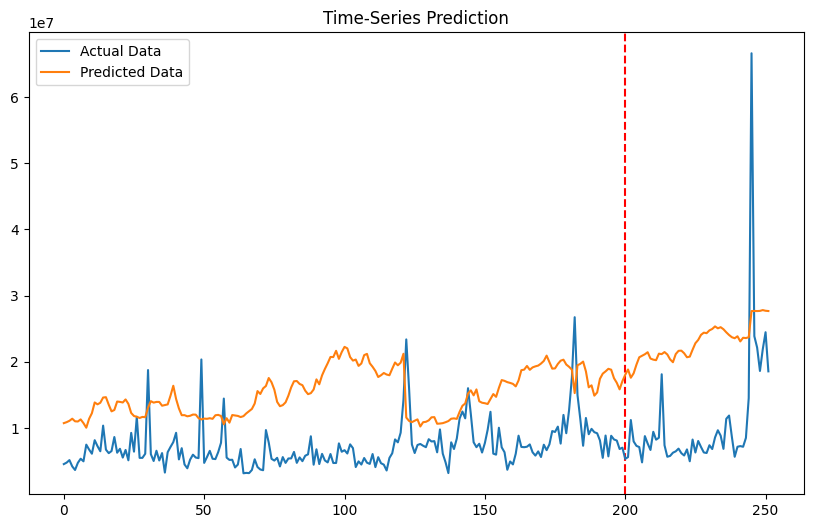

In [ ]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()